<a href="https://colab.research.google.com/github/Frknslmn50/EARIN_23L/blob/master/Training_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FashionMNIST Classification using ANN

* Importing Necessary Libraries:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Getting device type we are working with to train model and data on proper device:

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

* Loading the Dataset:

In [12]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),   # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize pixel values to range [-1, 1]
])

# Load FashionMNIST training set
train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load FashionMNIST test set
test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

* Creating the dataloaders by specifying the batch size (32 default):

In [13]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=True
)

Here we can see the target classes:

In [14]:
# Output labels
print(train_set.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Let's see the number of channels and pixels in each image:

In [15]:
# size of the images
print(train_set[0][0].shape)

torch.Size([1, 28, 28])


Images are in grayscale form, so we have only one channel.

Here we can have a look at the data we are working with:

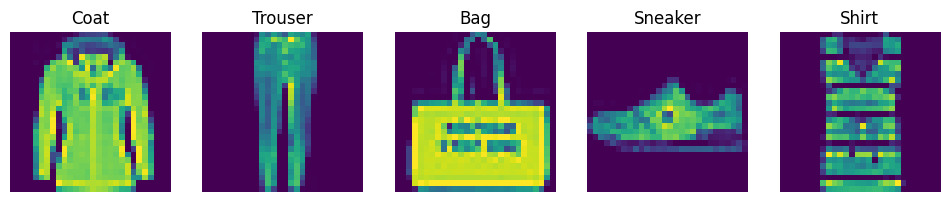

In [16]:
import matplotlib.pyplot as plt
# Get a few random images from the training set
indices = np.random.choice(len(train_set), 5, replace=False)
images = [train_set[i][0] for i in indices]
labels = [train_set[i][1] for i in indices]

# Plot the images with their categories
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax[i].imshow(images[i].permute(1, 2, 0).numpy())
    ax[i].set_title(train_set.classes[labels[i]])
    ax[i].axis('off')
plt.show()

* Defining the Neural Network:

In [17]:
# Define the neural network with given parameters : num of hidden layers, num of neurons in each layer
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons, num_classes, dropout_prob=0):
        super(NeuralNetwork, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout_prob)
        if(num_hidden_layers==0):
          self.layers.append(nn.Linear(784, num_classes))
        else:
          self.layers.append(nn.Linear(784, num_neurons[0]))
          self.layers.append(nn.ReLU())
          self.layers.append(self.dropout)
          for i in range(1, num_hidden_layers):
              self.layers.append(nn.Linear(num_neurons[i-1], num_neurons[i]))
              self.layers.append(nn.ReLU())
              self.layers.append(self.dropout)
          self.layers.append(nn.Linear(num_neurons[-1], num_classes))

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

* Defining the Function to calculate the accuracy based on the proportion of correct predictions to the total number of predictions:

In [18]:
def evaluate(model, dataloader):
    model.eval()
    total = 0
    correct = 0
    device = next(model.parameters()).device
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device) # move data to the same device as the model
            labels = labels.to(device) # move data to the same device as the model
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

* Defining the Function to train the model with specified number of epochs, learning rate,optmizer and loss function:

In [19]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=5,verbose=False):
    model.to(device)
    criterion.to(device)
    train_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    no_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_total = 0
        train_correct = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if verbose == True and (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Compute train and validation accuracies
        train_acc = train_correct / train_total
        val_acc = evaluate(model, val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        train_losses.append(train_loss/len(train_loader.dataset))
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    return train_losses, train_accs, val_accs 

* Defining the Function to plot the loss and accuracy curves:

In [20]:
def plot_train_history(train_losses, train_accs, val_accs):
    fig, ax = plt.subplots(1, 2, figsize=(9, 3))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].plot(train_accs, label='Train')
    ax[1].plot(val_accs, label='Validation')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

## Experiments:

### 1- Independent Variable : Learning Rate

* Learning Rate = 0.001

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15,verbose=False)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8285, Val Acc: 0.8503
Epoch [2/15], Train Acc: 0.8638, Val Acc: 0.8500
Epoch [3/15], Train Acc: 0.8759, Val Acc: 0.8565
Epoch [4/15], Train Acc: 0.8843, Val Acc: 0.8718
Epoch [5/15], Train Acc: 0.8916, Val Acc: 0.8743
Epoch [6/15], Train Acc: 0.8974, Val Acc: 0.8703
Epoch [7/15], Train Acc: 0.9040, Val Acc: 0.8787
Epoch [8/15], Train Acc: 0.9080, Val Acc: 0.8761
Epoch [9/15], Train Acc: 0.9119, Val Acc: 0.8683
Epoch [10/15], Train Acc: 0.9131, Val Acc: 0.8801
Epoch [11/15], Train Acc: 0.9175, Val Acc: 0.8775
Epoch [12/15], Train Acc: 0.9198, Val Acc: 0.8828
Epoch [13/15], Train Acc: 0.9224, Val Acc: 0.8777
Epoch [14/15], Train Acc: 0.9254, Val Acc: 0.8837
Epoch [15/15], Train Acc: 0.9278, Val Acc: 0.88

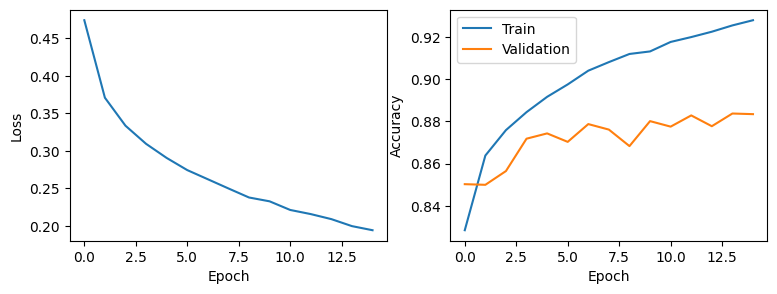

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

* Learning Rate = 0.005

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15,verbose=False)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8118, Val Acc: 0.8367
Epoch [2/15], Train Acc: 0.8435, Val Acc: 0.8382
Epoch [3/15], Train Acc: 0.8541, Val Acc: 0.8455
Epoch [4/15], Train Acc: 0.8611, Val Acc: 0.8426
Epoch [5/15], Train Acc: 0.8632, Val Acc: 0.8487
Epoch [6/15], Train Acc: 0.8677, Val Acc: 0.8506
Epoch [7/15], Train Acc: 0.8685, Val Acc: 0.8491
Epoch [8/15], Train Acc: 0.8719, Val Acc: 0.8456
Epoch [9/15], Train Acc: 0.8733, Val Acc: 0.8451
Epoch [10/15], Train Acc: 0.8756, Val Acc: 0.8518
Epoch [11/15], Train Acc: 0.8775, Val Acc: 0.8537
Epoch [12/15], Train Acc: 0.8791, Val Acc: 0.8401
Epoch [13/15], Train Acc: 0.8803, Val Acc: 0.8632
Epoch [14/15], Train Acc: 0.8799, Val Acc: 0.8448
Epoch [15/15], Train Acc: 0.8816, Val Acc: 0.85

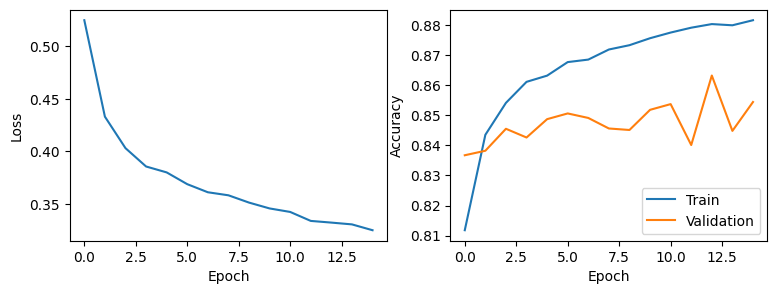

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

Here we can see that the accuracy decreases with increase in learning rate and also model is having a hard time to converge. Taking average of two learning rates, we get learning rate = 0.003.

* Learning Rate = 0.003 (Medium)

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15,verbose=False)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8155, Val Acc: 0.8322
Epoch [2/15], Train Acc: 0.8537, Val Acc: 0.8396
Epoch [3/15], Train Acc: 0.8682, Val Acc: 0.8599
Epoch [4/15], Train Acc: 0.8750, Val Acc: 0.8555
Epoch [5/15], Train Acc: 0.8781, Val Acc: 0.8615
Epoch [6/15], Train Acc: 0.8830, Val Acc: 0.8577
Epoch [7/15], Train Acc: 0.8865, Val Acc: 0.8650
Epoch [8/15], Train Acc: 0.8884, Val Acc: 0.8716
Epoch [9/15], Train Acc: 0.8917, Val Acc: 0.8667
Epoch [10/15], Train Acc: 0.8931, Val Acc: 0.8670
Epoch [11/15], Train Acc: 0.8955, Val Acc: 0.8687
Epoch [12/15], Train Acc: 0.8989, Val Acc: 0.8665
Epoch [13/15], Train Acc: 0.8988, Val Acc: 0.8666
Epoch [14/15], Train Acc: 0.9006, Val Acc: 0.8650
Epoch [15/15], Train Acc: 0.9031, Val Acc: 0.86

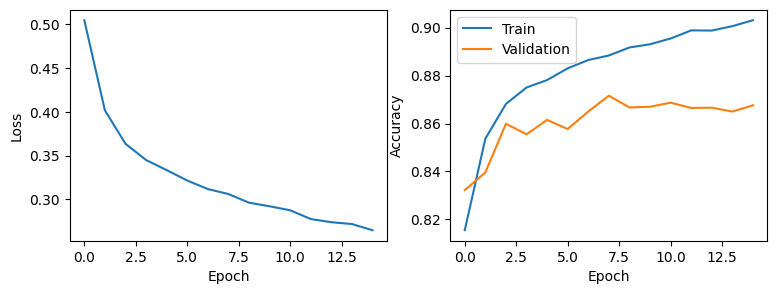

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

We can conclude that the model is performing best with learning rate = 0.001. So, we will use this learning rate for further experiments. And we can see as the learning rate increases, even though model converges faster it is having a hard time to converge to optimum and even diverges in some epochs.

### 2- Independent Variable : Mini Batch Size

* Mini Batch Size = 1

In [ ]:
mb_size = 1
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=mb_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=mb_size,
    shuffle=True
)

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8096, Val Acc: 0.8319
Epoch [2/15], Train Acc: 0.8425, Val Acc: 0.8287
Epoch [3/15], Train Acc: 0.8498, Val Acc: 0.8403
Epoch [4/15], Train Acc: 0.8552, Val Acc: 0.8380
Epoch [5/15], Train Acc: 0.8564, Val Acc: 0.8173
Epoch [6/15], Train Acc: 0.8604, Val Acc: 0.8460
Epoch [7/15], Train Acc: 0.8610, Val Acc: 0.8488
Epoch [8/15], Train Acc: 0.8658, Val Acc: 0.8521
Epoch [9/15], Train Acc: 0.8651, Val Acc: 0.8354
Epoch [10/15], Train Acc: 0.8661, Val Acc: 0.8490
Epoch [11/15], Train Acc: 0.8658, Val Acc: 0.8486
Epoch [12/15], Train Acc: 0.8698, Val Acc: 0.8322
Epoch [13/15], Train Acc: 0.8701, Val Acc: 0.8422
Epoch [14/15], Train Acc: 0.8708, Val Acc: 0.8394
Epoch [15/15], Train Acc: 0.8699, Val Acc: 0.83

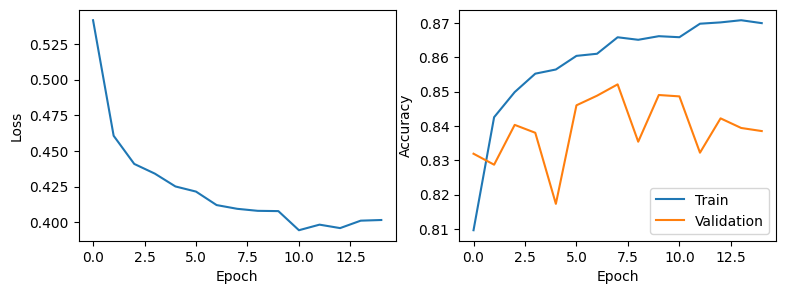

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

As we are using 1 data to update parameters every iteration it's having a hard time to converge to optimum and accuracy is low.

* Mini Batch Size = 32

In [ ]:
mb_size = 32
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=mb_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=mb_size,
    shuffle=True
)

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8256, Val Acc: 0.8468
Epoch [2/15], Train Acc: 0.8641, Val Acc: 0.8547
Epoch [3/15], Train Acc: 0.8770, Val Acc: 0.8726
Epoch [4/15], Train Acc: 0.8864, Val Acc: 0.8670
Epoch [5/15], Train Acc: 0.8916, Val Acc: 0.8676
Epoch [6/15], Train Acc: 0.8966, Val Acc: 0.8771
Epoch [7/15], Train Acc: 0.9012, Val Acc: 0.8734
Epoch [8/15], Train Acc: 0.9056, Val Acc: 0.8723
Epoch [9/15], Train Acc: 0.9078, Val Acc: 0.8767
Epoch [10/15], Train Acc: 0.9131, Val Acc: 0.8767
Epoch [11/15], Train Acc: 0.9163, Val Acc: 0.8759
Epoch [12/15], Train Acc: 0.9190, Val Acc: 0.8784
Epoch [13/15], Train Acc: 0.9233, Val Acc: 0.8850
Epoch [14/15], Train Acc: 0.9228, Val Acc: 0.8777
Epoch [15/15], Train Acc: 0.9267, Val Acc: 0.88

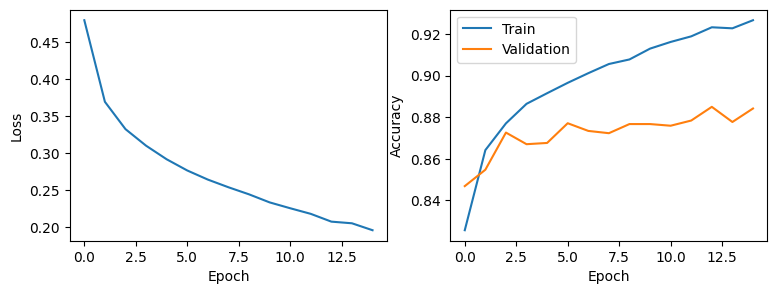

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

Much more better than previous one because we are taking average of 32 before every update which helps model to converge in a more accurate direction.

* Mini Batch Size = 16

In [ ]:
mb_size = 16
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=mb_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=mb_size,
    shuffle=True
)

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8242, Val Acc: 0.8430
Epoch [2/15], Train Acc: 0.8626, Val Acc: 0.8619
Epoch [3/15], Train Acc: 0.8755, Val Acc: 0.8624
Epoch [4/15], Train Acc: 0.8836, Val Acc: 0.8627
Epoch [5/15], Train Acc: 0.8897, Val Acc: 0.8736
Epoch [6/15], Train Acc: 0.8944, Val Acc: 0.8691
Epoch [7/15], Train Acc: 0.8992, Val Acc: 0.8677
Epoch [8/15], Train Acc: 0.9038, Val Acc: 0.8695
Epoch [9/15], Train Acc: 0.9064, Val Acc: 0.8802
Epoch [10/15], Train Acc: 0.9095, Val Acc: 0.8777
Epoch [11/15], Train Acc: 0.9125, Val Acc: 0.8753
Epoch [12/15], Train Acc: 0.9148, Val Acc: 0.8840
Epoch [13/15], Train Acc: 0.9178, Val Acc: 0.8803
Epoch [14/15], Train Acc: 0.9206, Val Acc: 0.8823
Epoch [15/15], Train Acc: 0.9198, Val Acc: 0.87

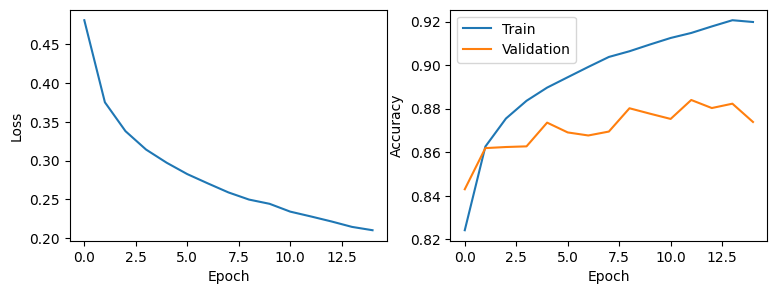

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

Based on experiments we can say batch size is critical for convergence of model. Best one of our experiments is with batch size = 32 so we will be using it for further experiments.

In [ ]:
mb_size = 32
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=mb_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=mb_size,
    shuffle=True
)

### 3- Independent Variable : Number of Hidden Layers

* Number of hidden layers = 0

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=0, num_neurons=[], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8134, Val Acc: 0.8234
Epoch [2/15], Train Acc: 0.8425, Val Acc: 0.8347
Epoch [3/15], Train Acc: 0.8468, Val Acc: 0.8343
Epoch [4/15], Train Acc: 0.8502, Val Acc: 0.8344
Epoch [5/15], Train Acc: 0.8537, Val Acc: 0.8370
Epoch [6/15], Train Acc: 0.8529, Val Acc: 0.8344
Epoch [7/15], Train Acc: 0.8554, Val Acc: 0.8402
Epoch [8/15], Train Acc: 0.8538, Val Acc: 0.8379
Epoch [9/15], Train Acc: 0.8567, Val Acc: 0.8276
Epoch [10/15], Train Acc: 0.8568, Val Acc: 0.8286
Epoch [11/15], Train Acc: 0.8579, Val Acc: 0.8388
Epoch [12/15], Train Acc: 0.8592, Val Acc: 0.8281
Epoch [13/15], Train Acc: 0.8606, Val Acc: 0.8333
Epoch [14/15], Train Acc: 0.8601, Val Acc: 0.8357
Epoch [15/15], Train Acc: 0.8592, Val Acc: 0.8335


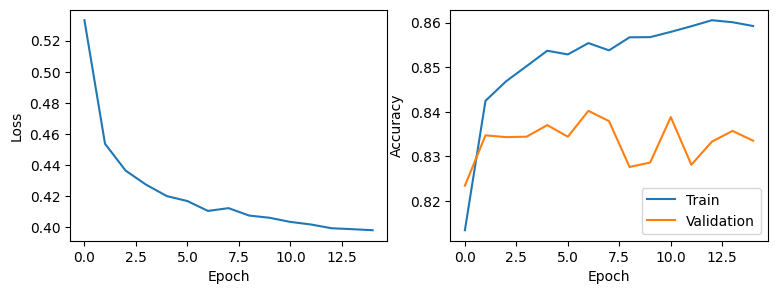

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

It's underfitting and even diverging by going further.

* Number of hidden layers = 1

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8250, Val Acc: 0.8477
Epoch [2/15], Train Acc: 0.8640, Val Acc: 0.8540
Epoch [3/15], Train Acc: 0.8764, Val Acc: 0.8675
Epoch [4/15], Train Acc: 0.8858, Val Acc: 0.8577
Epoch [5/15], Train Acc: 0.8922, Val Acc: 0.8722
Epoch [6/15], Train Acc: 0.8979, Val Acc: 0.8685
Epoch [7/15], Train Acc: 0.9033, Val Acc: 0.8782
Epoch [8/15], Train Acc: 0.9072, Val Acc: 0.8779
Epoch [9/15], Train Acc: 0.9103, Val Acc: 0.8771
Epoch [10/15], Train Acc: 0.9136, Val Acc: 0.8748
Epoch [11/15], Train Acc: 0.9168, Val Acc: 0.8773
Epoch [12/15], Train Acc: 0.9192, Val Acc: 0.8785
Epoch [13/15], Train Acc: 0.9218, Val Acc: 0.8817
Epoch [14/15], Train Acc: 0.9240, Val Acc: 0.8831
Epoch [15/15], Train Acc: 0.9289, Val Acc: 0.88

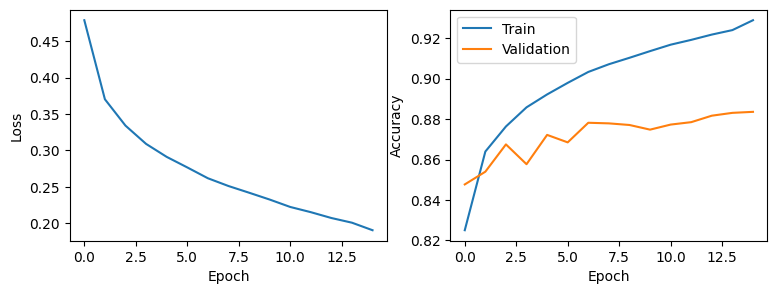

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

This one is better than 0 layer and also able to converge to optimum.

* Number of hidden layers = 2

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=2, num_neurons=[256,64], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8232, Val Acc: 0.8395
Epoch [2/15], Train Acc: 0.8627, Val Acc: 0.8563
Epoch [3/15], Train Acc: 0.8756, Val Acc: 0.8603
Epoch [4/15], Train Acc: 0.8857, Val Acc: 0.8687
Epoch [5/15], Train Acc: 0.8924, Val Acc: 0.8715
Epoch [6/15], Train Acc: 0.8969, Val Acc: 0.8777
Epoch [7/15], Train Acc: 0.9016, Val Acc: 0.8730
Epoch [8/15], Train Acc: 0.9053, Val Acc: 0.8766
Epoch [9/15], Train Acc: 0.9115, Val Acc: 0.8793
Epoch [10/15], Train Acc: 0.9140, Val Acc: 0.8815
Epoch [11/15], Train Acc: 0.9173, Val Acc: 0.8844
Epoch [12/15], Train Acc: 0.9198, Val Acc: 0.8873
Epoch [13/15], Train Acc: 0.9235, 

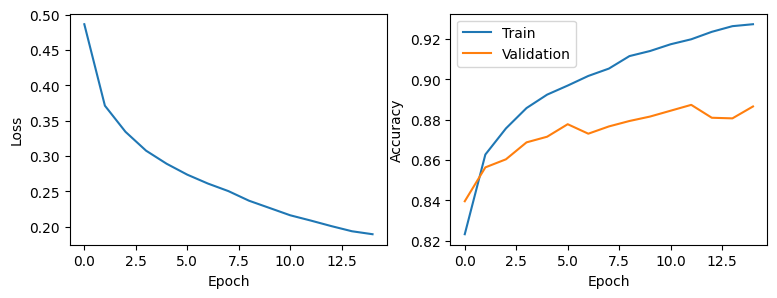

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

Slightly better than 1 hidden layer model, going beyond 2 layers has a risk of overfitting so this one seems ideal.

### 4- Independent Variable : Width (Number of neurons in hidden layer)

For this one we will use 1 hidden layer architecture with varying number of neurons.

* Number of neurons = 64

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[64], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8197, Val Acc: 0.8405
Epoch [2/15], Train Acc: 0.8588, Val Acc: 0.8567
Epoch [3/15], Train Acc: 0.8717, Val Acc: 0.8610
Epoch [4/15], Train Acc: 0.8783, Val Acc: 0.8643
Epoch [5/15], Train Acc: 0.8850, Val Acc: 0.8690
Epoch [6/15], Train Acc: 0.8892, Val Acc: 0.8703
Epoch [7/15], Train Acc: 0.8930, Val Acc: 0.8654
Epoch [8/15], Train Acc: 0.8976, Val Acc: 0.8724
Epoch [9/15], Train Acc: 0.8992, Val Acc: 0.8733
Epoch [10/15], Train Acc: 0.9012, Val Acc: 0.8733
Epoch [11/15], Train Acc: 0.9039, Val Acc: 0.8748
Epoch [12/15], Train Acc: 0.9072, Val Acc: 0.8766
Epoch [13/15], Train Acc: 0.9085, Val Acc: 0.8761
Epoch [14/15], Train Acc: 0.9118, Val Acc: 0.8788
Epoch [15/15], Train Acc: 0.9137, Val Acc: 0.8732

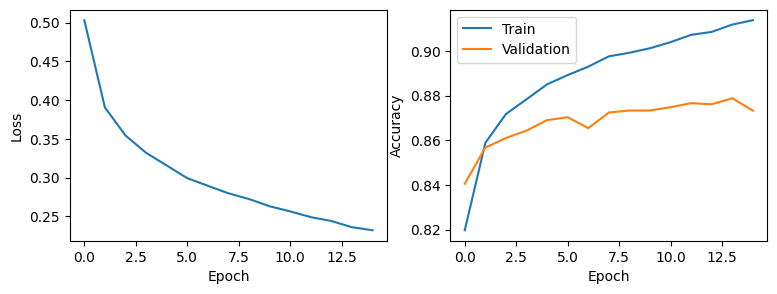

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

* Number of neurons = 128

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[128], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8238, Val Acc: 0.8424
Epoch [2/15], Train Acc: 0.8626, Val Acc: 0.8516
Epoch [3/15], Train Acc: 0.8744, Val Acc: 0.8594
Epoch [4/15], Train Acc: 0.8838, Val Acc: 0.8732
Epoch [5/15], Train Acc: 0.8892, Val Acc: 0.8660
Epoch [6/15], Train Acc: 0.8949, Val Acc: 0.8697
Epoch [7/15], Train Acc: 0.9009, Val Acc: 0.8703
Epoch [8/15], Train Acc: 0.9028, Val Acc: 0.8764
Epoch [9/15], Train Acc: 0.9068, Val Acc: 0.8757
Epoch [10/15], Train Acc: 0.9097, Val Acc: 0.8812
Epoch [11/15], Train Acc: 0.9135, Val Acc: 0.8798
Epoch [12/15], Train Acc: 0.9147, Val Acc: 0.8820
Epoch [13/15], Train Acc: 0.9181, Val Acc: 0.8795
Epoch [14/15], Train Acc: 0.9204, Val Acc: 0.8715
Epoch [15/15], Train Acc: 0.9223, Val Acc: 0.87

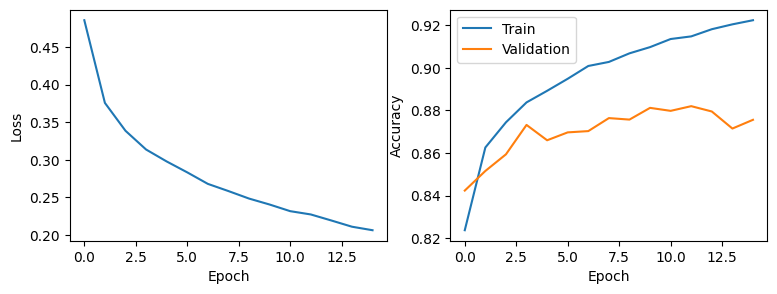

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

* Number of hidden layers = 256

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=1, num_neurons=[256], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8235, Val Acc: 0.8409
Epoch [2/15], Train Acc: 0.8629, Val Acc: 0.8568
Epoch [3/15], Train Acc: 0.8784, Val Acc: 0.8629
Epoch [4/15], Train Acc: 0.8856, Val Acc: 0.8617
Epoch [5/15], Train Acc: 0.8900, Val Acc: 0.8657
Epoch [6/15], Train Acc: 0.8954, Val Acc: 0.8744
Epoch [7/15], Train Acc: 0.9002, Val Acc: 0.8769
Epoch [8/15], Train Acc: 0.9035, Val Acc: 0.8700
Epoch [9/15], Train Acc: 0.9074, Val Acc: 0.8772
Epoch [10/15], Train Acc: 0.9110, Val Acc: 0.8816
Epoch [11/15], Train Acc: 0.9134, Val Acc: 0.8840
Epoch [12/15], Train Acc: 0.9158, Val Acc: 0.8795
Epoch [13/15], Train Acc: 0.9177, Val Acc: 0.8799
Epoch [14/15], Train Acc: 0.9203, Val Acc: 0.8807
Epoch [15/15], Train Acc: 0.9227, Val Acc: 0.88

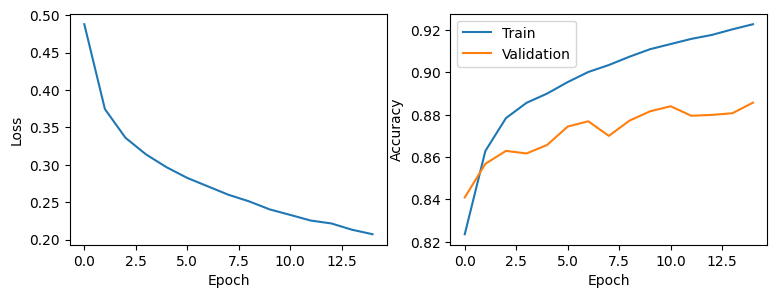

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

Increasing number of neurons allow model to learn more features and that results in a better accuracy but here we should be careful about overfitting before we select bigger numbers.

### 5- Independent Variable : Optimizer

* Stochastic Gradient Descent (SGD): a simple and widely used optimization algorithm that updates the model parameters using the gradients of the loss function.

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=2, num_neurons=[256,64], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.4663, Val Acc: 0.6748
Epoch [2/15], Train Acc: 0.7096, Val Acc: 0.7286
Epoch [3/15], Train Acc: 0.7451, Val Acc: 0.7501
Epoch [4/15], Train Acc: 0.7628, Val Acc: 0.7669
Epoch [5/15], Train Acc: 0.7790, Val Acc: 0.7746
Epoch [6/15], Train Acc: 0.7908, Val Acc: 0.7805
Epoch [7/15], Train Acc: 0.8002, Val Acc: 0.7901
Epoch [8/15], Train Acc: 0.8089, Val Acc: 0.7986
Epoch [9/15], Train Acc: 0.8161, Val Acc: 0.8055
Epoch [10/15], Train Acc: 0.8221, Val Acc: 0.8077
Epoch [11/15], Train Acc: 0.8259, Val Acc: 0.8141
Epoch [12/15], Train Acc: 0.8298, Val Acc: 0.8163
Epoch [13/15], Train Acc: 0.8332, 

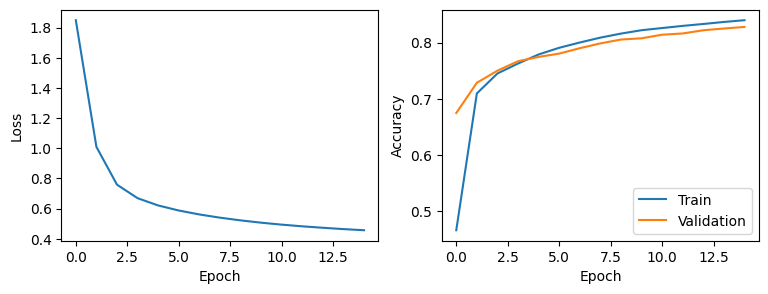

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

* AdaGrad: an optimization algorithm that adapts the learning rate for each parameter based on its historical gradients. It performs larger updates for infrequent parameters and smaller updates for frequent parameters.

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=2, num_neurons=[256,64], num_classes=10)
print(model)

# Define the loss function and optimizer
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(),lr=0.001)


# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.7856, Val Acc: 0.8029
Epoch [2/15], Train Acc: 0.8229, Val Acc: 0.8211
Epoch [3/15], Train Acc: 0.8338, Val Acc: 0.8244
Epoch [4/15], Train Acc: 0.8391, Val Acc: 0.8285
Epoch [5/15], Train Acc: 0.8427, Val Acc: 0.8319
Epoch [6/15], Train Acc: 0.8449, Val Acc: 0.8337
Epoch [7/15], Train Acc: 0.8472, Val Acc: 0.8354
Epoch [8/15], Train Acc: 0.8493, Val Acc: 0.8363
Epoch [9/15], Train Acc: 0.8510, Val Acc: 0.8379
Epoch [10/15], Train Acc: 0.8533, Val Acc: 0.8380
Epoch [11/15], Train Acc: 0.8544, Val Acc: 0.8414
Epoch [12/15], Train Acc: 0.8556, Val Acc: 0.8404
Epoch [13/15], Train Acc: 0.8573, 

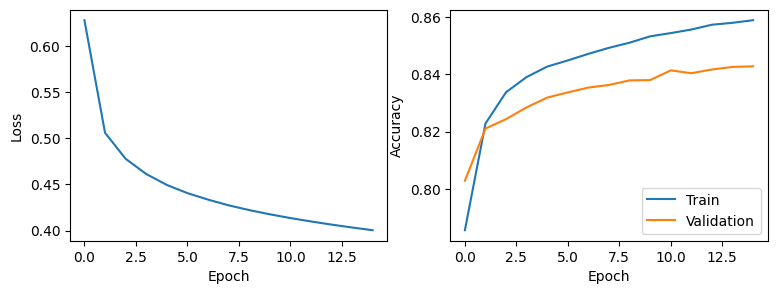

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

* Adam: an adaptive optimization algorithm that combines the advantages of the AdaGrad and RMSProp algorithms. It uses a running average of the gradients and squared gradients to update the model parameters.

In [ ]:
# Define the model
model = NeuralNetwork(num_hidden_layers=2, num_neurons=[256,64], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/15], Train Acc: 0.8238, Val Acc: 0.8387
Epoch [2/15], Train Acc: 0.8642, Val Acc: 0.8591
Epoch [3/15], Train Acc: 0.8765, Val Acc: 0.8600
Epoch [4/15], Train Acc: 0.8870, Val Acc: 0.8678
Epoch [5/15], Train Acc: 0.8907, Val Acc: 0.8683
Epoch [6/15], Train Acc: 0.8964, Val Acc: 0.8718
Epoch [7/15], Train Acc: 0.9018, Val Acc: 0.8795
Epoch [8/15], Train Acc: 0.9052, Val Acc: 0.8802
Epoch [9/15], Train Acc: 0.9098, Val Acc: 0.8795
Epoch [10/15], Train Acc: 0.9139, Val Acc: 0.8828
Epoch [11/15], Train Acc: 0.9169, Val Acc: 0.8851
Epoch [12/15], Train Acc: 0.9189, Val Acc: 0.8795
Epoch [13/15], Train Acc: 0.9226, 

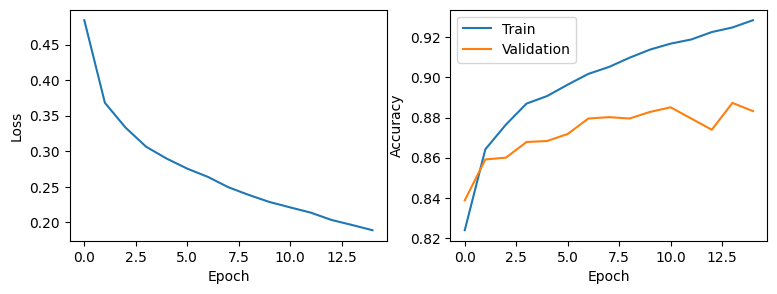

In [ ]:
plot_train_history(train_losses, train_accs, val_accs)

Here we can see the predictions of our model and true labels:

* Final Model (Based on the experiments)

In [22]:
# Define the model
model = NeuralNetwork(num_hidden_layers=2, num_neurons=[256,64], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=25)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/25], Train Acc: 0.8232, Val Acc: 0.8418
Epoch [2/25], Train Acc: 0.8630, Val Acc: 0.8515
Epoch [3/25], Train Acc: 0.8775, Val Acc: 0.8669
Epoch [4/25], Train Acc: 0.8853, Val Acc: 0.8670
Epoch [5/25], Train Acc: 0.8914, Val Acc: 0.8605
Epoch [6/25], Train Acc: 0.8968, Val Acc: 0.8811
Epoch [7/25], Train Acc: 0.9018, Val Acc: 0.8752
Epoch [8/25], Train Acc: 0.9068, Val Acc: 0.8738
Epoch [9/25], Train Acc: 0.9108, Val Acc: 0.8757
Epoch [10/25], Train Acc: 0.9123, Val Acc: 0.8828
Epoch [11/25], Train Acc: 0.9163, Val Acc: 0.8828
Epoch [12/25], Train Acc: 0.9195, Val Acc: 0.8846
Epoch [13/25], Train Acc: 0.9233, 

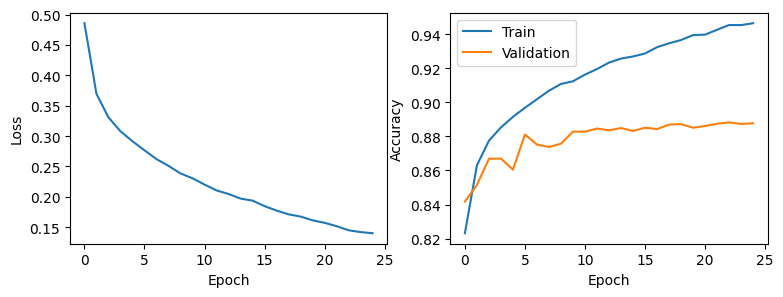

In [23]:
plot_train_history(train_losses, train_accs, val_accs)

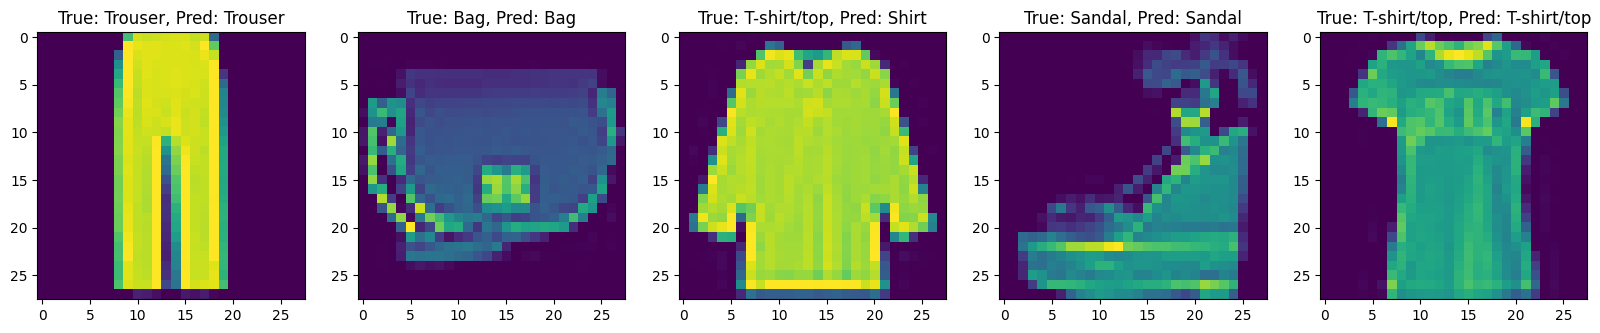

In [38]:
# Set model to evaluation mode
model.eval()

# Get a batch of test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert labels and predictions to numpy arrays and to categorical labels
labels = labels.cpu().numpy()
predicted = predicted.cpu().numpy()
images = images.cpu()
# Show some predictions and true labels
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())
    axs[i].set_title(f'True: {test_set.classes[labels[i]]}, Pred: {test_set.classes[predicted[i]]}')
plt.show()

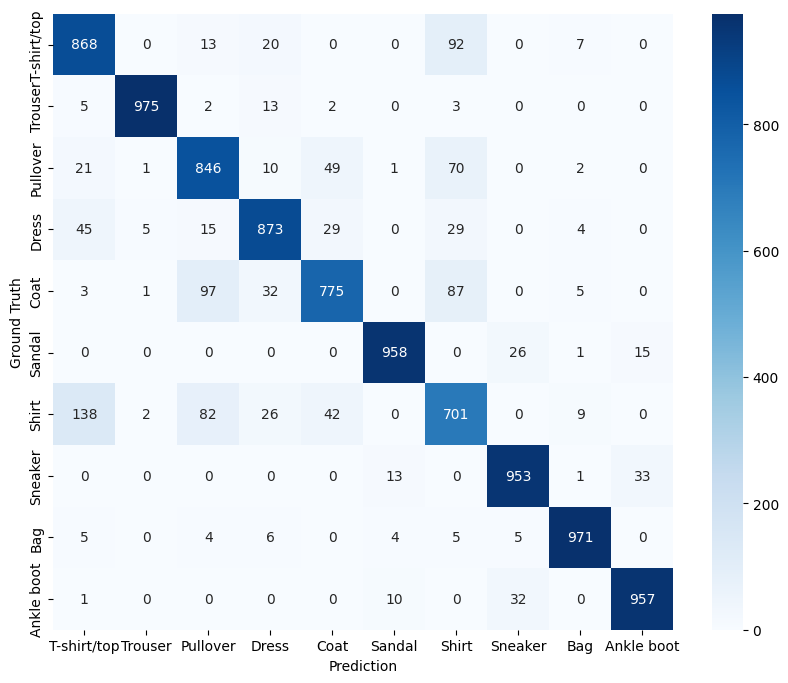

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# test the model on the test set and plot the confusion matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.append(predicted.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())
y_pred_list = np.concatenate(y_pred_list).ravel().tolist()
y_true_list = np.concatenate(y_true_list).ravel().tolist()
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list), index=test_set.classes, columns=test_set.classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

In [26]:
# Precision, Recall, F1 score
from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, target_names=test_set.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.87      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.85      0.82      1000
       Dress       0.89      0.87      0.88      1000
        Coat       0.86      0.78      0.82      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.71      0.70      0.71      1000
     Sneaker       0.94      0.95      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

